In [49]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [50]:
def f(t, y, pars, od_sp):
    X1, X2, S, I, P = y
    S0, k1, KS1, k2, KI2, mu1max, mu2max, KSmu, Y  = pars
    if callable(mu1max):
        mu1 = mu1max(t) * S / (KSmu + S)
    else:
        mu1 = mu1max * S / (KSmu + S)
    if callable(mu2max):
        mu2 = mu2max(t) * S / (KSmu + S)
    else:
        mu2 = mu2max * S / (KSmu + S)

    if X1 + X2 > od_sp:
        d = (mu1 * X1 + mu2 * X2) / (X1 + X2)
    else:
        d = 0

    dX1dt = (mu1 - d) * X1
    dX2dt = (mu2 - d) * X2

    dSdt = d * (S0 - S) - k1 * X1 * S / (KS1 + S) - (mu1*X1 + mu2*X2) * Y
    dIdt = k1 * X1 * S / (KS1 + S) - k2 * X2 * I / (KI2 + I) - d * I
    dPdt = k2 * X2 * I / (KI2 + I) - d * P

    return [dX1dt, dX2dt, dSdt, dIdt, dPdt]

In [51]:
Ks = 2
Y = 2

S0 = 20
k1 = 0.2
KS1 = 1
k2 = 0.2
KI2 = 1
mu1max = 0.3
mu2max = 0.3
KSmu = 1
Y = 2

pars = S0, k1, KS1, k2, KI2, mu1max, mu2max, KSmu, Y

/tmp/ipykernel_3013492/2922031500.py:37: RuntimeWarning: invalid value encountered in divide
  ax2.plot(sol.t, sol.y[4]/sol.t, label='P over t', color='green')


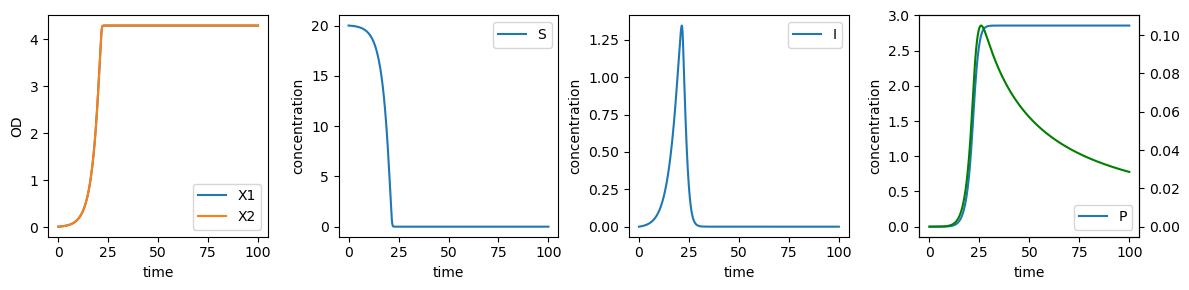

In [52]:

tspan = [0, 100]
y0 = [0.01, 0.01, S0, 0, 0]
od_sp = 100

sol = solve_ivp(lambda t, y: f(t, y, pars, od_sp), tspan, y0, method='LSODA', t_eval=np.linspace(0, 100, 1000))

plot = True

if plot:
    fig = plt.figure(figsize=(12, 3))
    ax = fig.add_subplot(141)
    ax.plot(sol.t, sol.y[0], label='X1')
    ax.plot(sol.t, sol.y[1], label='X2')
    ax.set_xlabel('time')
    ax.set_ylabel('OD')
    ax.legend()

    ax = fig.add_subplot(142)
    ax.plot(sol.t, sol.y[2], label='S')
    ax.set_xlabel('time')
    ax.set_ylabel('concentration')
    ax.legend()

    ax = fig.add_subplot(143)
    ax.plot(sol.t, sol.y[3], label='I')
    ax.set_xlabel('time')
    ax.set_ylabel('concentration')
    ax.legend()

    ax = fig.add_subplot(144)
    ax.plot(sol.t, sol.y[4], label='P')
    ax.set_xlabel('time')
    ax.set_ylabel('concentration')
    ax.legend()

    ax2 = ax.twinx()
    ax2.plot(sol.t, sol.y[4]/sol.t, label='P over t', color='green')
    plt.tight_layout()

In [63]:
def min_fun(x):
    X1X2_ratio, tmax = x
    tspan = [0, tmax]
    X10 = X1X2_ratio * 0.01 / (1 + X1X2_ratio)
    X20 = 0.01 - X10
    y0 = [X10, X20, S0, 0, 0]

    od_sp = 100

    sol = solve_ivp(lambda t, y: f(t, y, pars, od_sp), tspan, y0, method='BDF', t_eval=np.linspace(0, tmax, 1000), atol=1e-6, rtol=1e-9)

    return - (sol.y[4, -1] / sol.t[-1])

sol_min1 = minimize(min_fun, [1, 100], method='Nelder-Mead', options={'maxiter': 1000})
print(sol_min1)

plot = True
if plot:

    tspan = [0, 100]

    X1X2_ratio_ideal = sol_min1.x[0]
    X10 = X1X2_ratio_ideal * 0.01 / (1 + X1X2_ratio_ideal)
    X20 = 0.01 - X10

    y0 = [X10, X20, S0, 0, 0]
    od_sp = 100

    sol = solve_ivp(lambda t, y: f(t, y, pars, od_sp), tspan, y0, method='LSODA', t_eval=np.linspace(0, 100, 1000))

    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(221)
    ax.plot(sol.t, sol.y[0], label=r'$X_1$', color='blue', linewidth=2)
    ax.plot(sol.t, sol.y[1], label=r'$X_2$', color='orange', linewidth=2)
    ax.tick_params(which='major', labelsize=20, pad=10, length=10, width=2, direction='in')
    ax.tick_params(which='minor', labelsize=20, pad=10, length=5, width=1, direction='in')
    [i.set_linewidth(3) for i in ax.spines.values()]
    ax.set_xlabel('Time (hr)', fontsize=20)
    ax.set_ylabel('OD', fontsize=20)
    ax.set_title('OD', fontsize=20)
    ax.legend(fontsize=20)

    ax = fig.add_subplot(222)
    ax.plot(sol.t, sol.y[2], label='S', color='black', linewidth=2)
    ax.set_xlabel('Time (hr)', fontsize=20)
    ax.set_ylabel('[S]] [g/L]', fontsize=20)
    ax.tick_params(which='major', labelsize=20, pad=10, length=10, width=2, direction='in')
    ax.tick_params(which='minor', labelsize=20, pad=10, length=5, width=1, direction='in')
    [i.set_linewidth(3) for i in ax.spines.values()]
    # ax.legend(fontsize=20)
    ax.set_title('Substrate', fontsize=20)

    ax = fig.add_subplot(223)
    ax.plot(sol.t, sol.y[3], label='I', linewidth=2, color='black')
    ax.set_xlabel('Time (hr)', fontsize=20)
    ax.set_ylabel('[I] [g/L]', fontsize=20)
    ax.tick_params(which='major', labelsize=20, pad=10, length=10, width=2, direction='in')
    ax.tick_params(which='minor', labelsize=20, pad=10, length=5, width=1, direction='in')
    [i.set_linewidth(3) for i in ax.spines.values()]
    # ax.legend(fontsize=20)
    ax.set_title('Intermediate', fontsize=20)

    ax = fig.add_subplot(224)
    ax.plot(sol.t, sol.y[4], label='P', linewidth=2, color='black')
    ax.set_xlabel('Time (hr)', fontsize=20)
    ax.set_ylabel('[P] [g/L]', fontsize=20)
    ax.tick_params(which='major', labelsize=20, pad=10, length=10, width=2, direction='in')
    ax.tick_params(which='minor', labelsize=20, pad=10, length=5, width=1, direction='in')
    [i.set_linewidth(3) for i in ax.spines.values()]
    ax.set_title('Product', fontsize=20)

    ax2 = ax.twinx()
    ax2.plot(sol.t, sol.y[4]/sol.t, label='P over t', color='green', linewidth=2)
    ax2.tick_params(which='major', labelsize=20, pad=10, length=10, width=2, direction='in', labelcolor='green')
    ax2.tick_params(which='minor', labelsize=20, pad=10, length=5, width=1, direction='in')
    ax2.set_ylabel('[P]/t [g/(L h)]', fontsize=20, color='green')
    plt.tight_layout()

In [59]:
def min_fun(x):
    X1X2_ratio, t_switch, tmax = x
    tspan = [0, t_switch]
    X10 = X1X2_ratio * 0.01 / (1 + X1X2_ratio)
    X20 = 0.01 - X10
    y0 = [X10, X20, S0, 0, 0]

    od_sp = 100
    pars = S0, k1, KS1, k2, KI2, mu1max, 0, KSmu, Y
    sol = solve_ivp(lambda t, y: f(t, y, pars, od_sp), tspan, y0, method='BDF', t_eval=np.linspace(0, t_switch, 1000), atol=1e-6, rtol=1e-9)

    if tmax > t_switch:
        tspan = [t_switch, tmax]
        y0 = sol.y[:, -1]
        pars = S0, k1, KS1, k2, KI2, 0, mu2max, KSmu, Y
        sol = solve_ivp(lambda t, y: f(t, y, pars, od_sp), tspan, y0, method='BDF', t_eval=np.linspace(t_switch, tmax, 1000), atol=1e-6, rtol=1e-9)

    # if tmax < t_switch:
    #     return - (sol.y[4, -1] / sol.t[-1]) + (t_switch - tmax) * 100
    # else:
    return - (sol.y[4, -1] / sol.t[-1])

sol_min2 = minimize(min_fun, [1, 30, 50], method='L-BFGS-B', options={'maxiter': 1000, 'eps': 1e-12, 'ftol': 1e-9, 'gtol': 1e-9, 'eps':1e-12, 'maxls': 100}, bounds=[(0, 100), (0.01, 100), (1, 100)], )
print(sol_min2)

      fun: -0.15423578802476595
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00052731, 0.00066726, 0.        ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 464
      nit: 51
     njev: 116
   status: 0
  success: True
        x: array([ 1.89810649, 19.90994849, 62.30475225])


/tmp/ipykernel_3013492/900552343.py:72: RuntimeWarning: invalid value encountered in divide
  ax2.plot(sol.t, sol.y[4]/sol.t, label='P over t', color='green', linewidth=2)


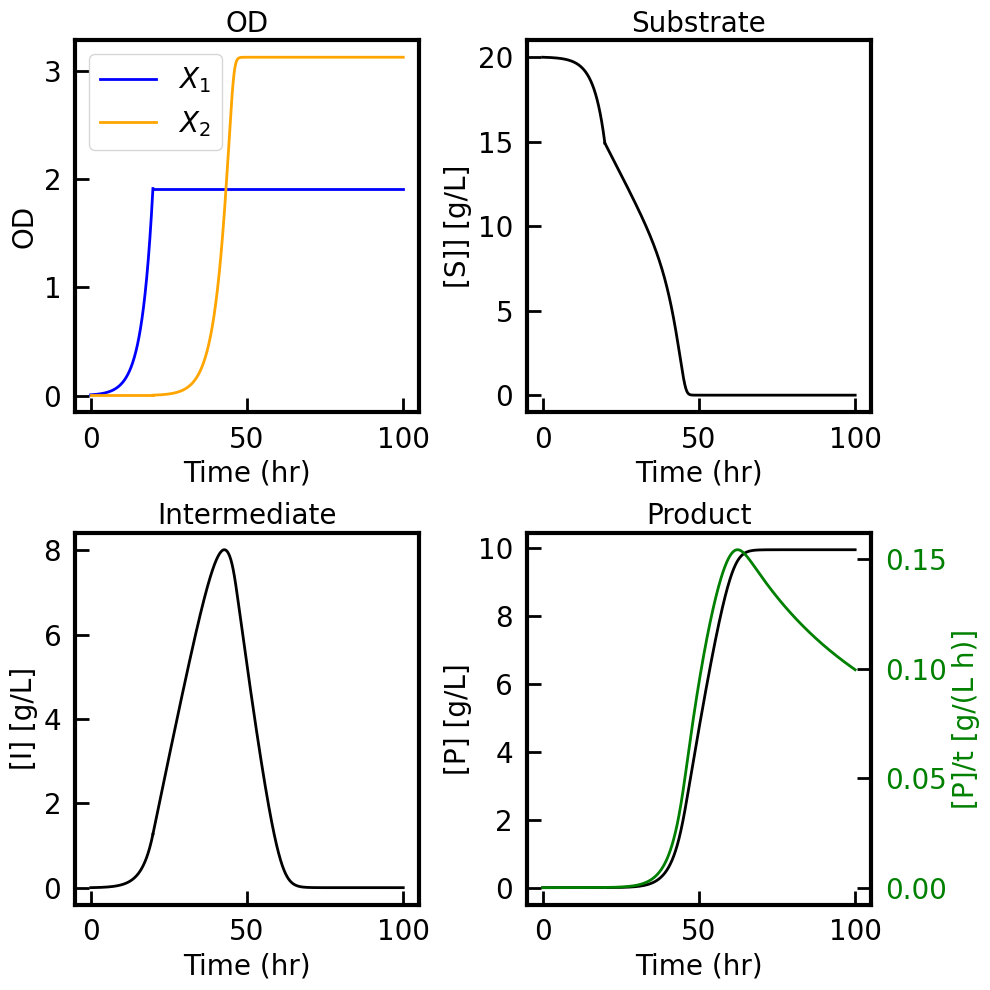

In [62]:
plot = True
if plot:
    X1X2_ratio_ideal = sol_min2.x[0]
    X10 = X1X2_ratio_ideal * 0.01 / (1 + X1X2_ratio_ideal)
    X20 = 0.01 - X10

    t_switch_ideal = sol_min2.x[1]

    y0 = [X10, X20, S0, 0, 0]
    od_sp = 100
    tspan = [0, t_switch_ideal]

    pars = S0, k1, KS1, k2, KI2, mu1max, 0, KSmu, Y
    sol = solve_ivp(lambda t, y: f(t, y, pars, od_sp), tspan, y0, method='LSODA', t_eval=np.linspace(0, t_switch_ideal, 1000))

    tspan = [t_switch_ideal, 100]
    y0 = sol.y[:, -1]
    pars = S0, k1, KS1, k2, KI2, 0, mu2max, KSmu, Y
    sol2 = solve_ivp(lambda t, y: f(t, y, pars, od_sp), tspan, y0, method='BDF', t_eval=np.linspace(t_switch_ideal, 100, 1000), atol=1e-6, rtol=1e-9)

    t_arr = np.concatenate((sol.t, sol2.t))
    y_arr = np.concatenate((sol.y, sol2.y), axis=1)

    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(221)
    ax.plot(sol.t, sol.y[0], label=r'$X_1$', color='blue', linewidth=2)
    ax.plot(sol.t, sol.y[1], label=r'$X_2$', color='orange', linewidth=2)
    ax.plot(sol2.t, sol2.y[0], color='blue', linewidth=2)
    ax.plot(sol2.t, sol2.y[1], color='orange', linewidth=2)
    ax.tick_params(which='major', labelsize=20, pad=10, length=10, width=2, direction='in')
    ax.tick_params(which='minor', labelsize=20, pad=10, length=5, width=1, direction='in')
    [i.set_linewidth(3) for i in ax.spines.values()]
    ax.set_xlabel('Time (hr)', fontsize=20)
    ax.set_ylabel('OD', fontsize=20)
    ax.set_title('OD', fontsize=20)
    ax.legend(fontsize=20)

    ax = fig.add_subplot(222)
    ax.plot(sol.t, sol.y[2], label='S', color='black', linewidth=2)
    ax.plot(sol2.t, sol2.y[2], color='black', linewidth=2)
    ax.set_xlabel('Time (hr)', fontsize=20)
    ax.set_ylabel('[S]] [g/L]', fontsize=20)
    ax.tick_params(which='major', labelsize=20, pad=10, length=10, width=2, direction='in')
    ax.tick_params(which='minor', labelsize=20, pad=10, length=5, width=1, direction='in')
    [i.set_linewidth(3) for i in ax.spines.values()]
    # ax.legend(fontsize=20)
    ax.set_title('Substrate', fontsize=20)

    ax = fig.add_subplot(223)
    ax.plot(sol.t, sol.y[3], label='I', linewidth=2, color='black')
    ax.plot(sol2.t, sol2.y[3], linewidth=2, color='black')
    ax.set_xlabel('Time (hr)', fontsize=20)
    ax.set_ylabel('[I] [g/L]', fontsize=20)
    ax.tick_params(which='major', labelsize=20, pad=10, length=10, width=2, direction='in')
    ax.tick_params(which='minor', labelsize=20, pad=10, length=5, width=1, direction='in')
    [i.set_linewidth(3) for i in ax.spines.values()]
    # ax.legend(fontsize=20)
    ax.set_title('Intermediate', fontsize=20)

    ax = fig.add_subplot(224)
    ax.plot(sol.t, sol.y[4], label='P', linewidth=2, color='black')
    ax.plot(sol2.t, sol2.y[4], linewidth=2, color='black')
    ax.set_xlabel('Time (hr)', fontsize=20)
    ax.set_ylabel('[P] [g/L]', fontsize=20)
    ax.tick_params(which='major', labelsize=20, pad=10, length=10, width=2, direction='in')
    ax.tick_params(which='minor', labelsize=20, pad=10, length=5, width=1, direction='in')
    [i.set_linewidth(3) for i in ax.spines.values()]
    ax.set_title('Product', fontsize=20)

    ax2 = ax.twinx()
    ax2.plot(sol.t, sol.y[4]/sol.t, label='P over t', color='green', linewidth=2)
    ax2.plot(sol2.t, sol2.y[4]/sol2.t, color='green', linewidth=2)
    ax2.tick_params(which='major', labelsize=20, pad=10, length=10, width=2, direction='in', labelcolor='green')
    ax2.tick_params(which='minor', labelsize=20, pad=10, length=5, width=1, direction='in')
    ax2.set_ylabel('[P]/t [g/(L h)]', fontsize=20, color='green')
    plt.tight_layout()

In [56]:
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

def min_fun(x):
    # for unit in x:
    #     unit = unit * 100
    X1X2_ratio, tmax, B, M, nu = x

    mu1max_fun = lambda t: (1 - 1 / (1 + np.exp(-B * (t - M))) ** (1 / nu)) * mu1max
    mu2max_fun = lambda t: (1 / (1 + np.exp(-B * (t - M))) ** (1 / nu)) * mu2max
    tspan = [0, tmax]
    X10 = X1X2_ratio * 0.01 / (1 + X1X2_ratio)
    X20 = 0.01 - X10
    y0 = [X10, X20, S0, 0, 0]

    od_sp = 100
    pars = S0, k1, KS1, k2, KI2, mu1max_fun, mu2max_fun, KSmu, Y
    sol = solve_ivp(lambda t, y: f(t, y, pars, od_sp), tspan, y0, method='BDF', t_eval=np.linspace(0, tmax, 1000), atol=1e-6, rtol=1e-9)

    # print('=====================================')
    # print(x)
    # print(sol.y[4, -1] / sol.t[-1])


    return - (sol.y[4, -1] / sol.t[-1])

sol_min3 = minimize(min_fun, np.array([1, 50, 10, 20, 1]), method='SLSQP', options={'maxiter': 1000, 'eps': 1e-12, 'ftol': 1e-9, 'eps':1e-12}, bounds=[(0, 100), (1, 100), (0, 100), (0, 100), (1e-10, 100)])
print(sol_min3)

/tmp/ipykernel_3013492/2420226220.py:9: RuntimeWarning: overflow encountered in double_scalars
  mu1max_fun = lambda t: (1 - 1 / (1 + np.exp(-B * (t - M))) ** (1 / nu)) * mu1max
/tmp/ipykernel_3013492/2420226220.py:10: RuntimeWarning: overflow encountered in double_scalars
  mu2max_fun = lambda t: (1 / (1 + np.exp(-B * (t - M))) ** (1 / nu)) * mu2max


     fun: -0.15383870845410605
     jac: array([-0.0026643 ,  0.        ,  0.00044405, -0.00061165, -0.00319161])
 message: 'Optimization terminated successfully'
    nfev: 357
     nit: 47
    njev: 47
  status: 0
 success: True
       x: array([ 3.57117877, 63.39257269,  7.22131156, 19.2834035 ,  1.71818355])


/tmp/ipykernel_3013492/1312460171.py:54: RuntimeWarning: invalid value encountered in divide
  ax2.plot(t_arr, y_arr[4]/t_arr, label='P over t', color='green')


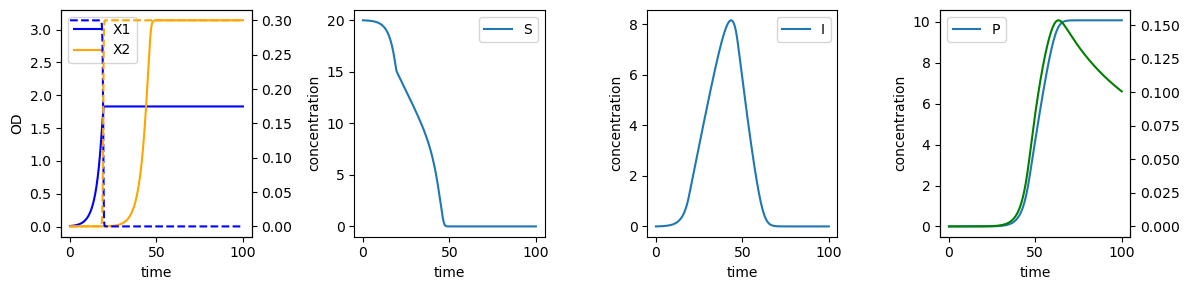

In [57]:
plot = True
if plot:
    X1X2_ratio, tmax, B, M, nu = sol_min3.x

    mu1max_fun = lambda t: (1 - 1 / (1 + np.exp(-B * (t - M))) ** (1 / nu)) * mu1max
    mu2max_fun = lambda t: (1 / (1 + np.exp(-B * (t - M))) ** (1 / nu)) * mu2max
    tspan = [0, 100]
    X10 = X1X2_ratio * 0.01 / (1 + X1X2_ratio)
    X20 = 0.01 - X10
    y0 = [X10, X20, S0, 0, 0]

    od_sp = 100
    pars = S0, k1, KS1, k2, KI2, mu1max_fun, mu2max_fun, KSmu, Y
    sol = solve_ivp(lambda t, y: f(t, y, pars, od_sp), tspan, y0, method='BDF', t_eval=np.linspace(0, 100, 1000), atol=1e-6, rtol=1e-9)

    t_arr = sol.t
    y_arr = sol.y

    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(12, 3))
    ax = fig.add_subplot(141)
    ax.plot(t_arr, y_arr[0], label='X1', color='blue')
    ax.plot(t_arr, y_arr[1], label='X2', color='orange')
    ax.set_xlabel('time')
    ax.set_ylabel('OD')
    # ax.set_xlim([0,25])
    ax.legend()

    ax2 = ax.twinx()
    ax2.plot(t_arr, mu1max_fun(t_arr), '--', label='X1_mu', color='blue')
    ax2.plot(t_arr, mu2max_fun(t_arr), '--', label='X2_mu', color='orange')
    # ax.set_xlim([0,25])
    # ax2.legend()

    ax = fig.add_subplot(142)
    ax.plot(t_arr, y_arr[2], label='S')
    ax.set_xlabel('time')
    ax.set_ylabel('concentration')
    ax.legend()

    ax = fig.add_subplot(143)
    ax.plot(t_arr, y_arr[3], label='I')
    ax.set_xlabel('time')
    ax.set_ylabel('concentration')
    ax.legend()

    ax = fig.add_subplot(144)
    ax.plot(t_arr, y_arr[4], label='P')
    ax.set_xlabel('time')
    ax.set_ylabel('concentration')
    ax.legend()

    ax2 = ax.twinx()
    ax2.plot(t_arr, y_arr[4]/t_arr, label='P over t', color='green')
    plt.tight_layout()

In [58]:
def min_fun(x):
    X1X2_ratio, t_switch1, t_switch2, tmax, muswitch1, muswitch2 = x
    
    X10 = X1X2_ratio * 0.01 / (1 + X1X2_ratio)
    X20 = 0.01 - X10
    y0 = [X10, X20, S0, 0, 0]

    tspan = [0, t_switch1]
    od_sp = 100
    pars = S0, k1, KS1, k2, KI2, mu1max, 0, KSmu, Y
    sol = solve_ivp(lambda t, y: f(t, y, pars, od_sp), tspan, y0, method='BDF', t_eval=np.linspace(0, t_switch1, 1000), atol=1e-6, rtol=1e-9)

    if t_switch2 > t_switch1:
        tspan = [t_switch1, t_switch2]
        y0 = sol.y[:, -1]
        pars = S0, k1, KS1, k2, KI2, mu1max-muswitch1, muswitch1, KSmu, Y
        sol = solve_ivp(lambda t, y: f(t, y, pars, od_sp), tspan, y0, method='BDF', t_eval=np.linspace(t_switch1, t_switch2, 1000), atol=1e-6, rtol=1e-9)

        if tmax > t_switch2:
            tspan = [t_switch2, tmax]
            y0 = sol.y[:, -1]
            pars = S0, k1, KS1, k2, KI2, mu1max-muswitch2, muswitch2, KSmu, Y
            sol = solve_ivp(lambda t, y: f(t, y, pars, od_sp), tspan, y0, method='BDF', t_eval=np.linspace(t_switch2, tmax, 1000), atol=1e-6, rtol=1e-9)


    return - (sol.y[4, -1] / sol.t[-1])

sol_min4 = minimize(min_fun, [1, 10, 20, 80, 0.15, 0.15], method='SLSQP', options={'maxiter': 1000, 'eps': 1e-6, 'ftol': 1e-9, 'gtol': 1e-9, 'maxls': 100}, bounds=[(0, 100), (0.01, 100), (0.01, 100), (1, 100), (0, mu1max), (0, mu1max)], )
print(sol_min4)

/tmp/ipykernel_3013492/3620307234.py:28: OptimizeWarning: Unknown solver options: gtol, maxls
  sol_min4 = minimize(min_fun, [1, 10, 20, 80, 0.15, 0.15], method='SLSQP', options={'maxiter': 1000, 'eps': 1e-6, 'ftol': 1e-9, 'gtol': 1e-9, 'maxls': 100}, bounds=[(0, 100), (0.01, 100), (0.01, 100), (1, 100), (0, mu1max), (0, mu1max)], )


     fun: -0.15425864266283884
     jac: array([-5.85920201e-08, -2.01866302e-07, -8.35165269e-08,  6.62248036e-08,
        2.83982529e-02, -3.37945521e-01])
 message: 'Optimization terminated successfully'
    nfev: 532
     nit: 74
    njev: 74
  status: 0
 success: True
       x: array([ 2.12163268,  9.94660655, 19.74351857, 62.3201796 ,  0.        ,
        0.3       ])
